### Introduction

Chapter VII -> Project Haberman Breast Cancer Classification

In [163]:
import pandas as pd
import numpy as np

### Data exploration

In [28]:
path = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/haberman.csv"
df = pd.read_csv(path, names = ['age','year','nodes','class'])

In [29]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,306.0,52.457516,10.803452,30.0,44.0,52.0,60.75,83.0
year,306.0,62.852941,3.249405,58.0,60.0,63.0,65.75,69.0
nodes,306.0,4.026144,7.189654,0.0,0.0,1.0,4.00,52.0
class,306.0,1.264706,0.441899,1.0,1.0,1.0,2.00,2.0


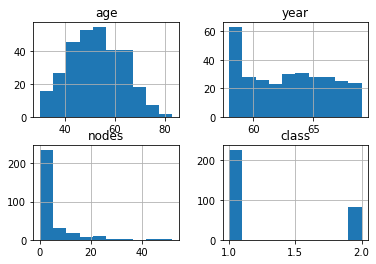

In [30]:
df.hist();

In [31]:
counter = df['class'].value_counts
pd.concat([
    counter() , counter(normalize=True) * 100
], axis=1, keys = ['class_count', 'class_pct']
)

,class_count,class_pct
1,225,73.529412
2,81,26.470588


### Baseline


Metric needed
Given that we are interested in predicting a probability of survival, we need a performancemetric that evaluates the skill of a model based on the predicted probabilities.  In this case,we  will  use  the  Brier  score  that  calculates  the  mean  squared  error  between  the  predictedprobabilities and the expected probabilities .
This can be calculated using the brier scoreloss() scikit-learn function.

A reference prediction for a problem in which we are predicting probabilities is the probability of the positive class label in the dataset.  In this case,  the positive classlabel represents non-survival and occurs about 26% in the dataset.  Therefore, predicting about 0.26471 represents the worst-case or baseline performance for a predictive model on this dataset.

Any model that has a Brier score better than this has some skill, where as any model thatas a Brier score lower than this has no skill.  The Brier Skill Score captures this importantrelationship.  We can calculate the Brier score for this default prediction strategy automaticallyfor each training set in thek-fold cross-validation process, then use it as a point of comparisonfor a given model.

In [106]:
y_true = (df['class'].values == 2).astype(int)
ref_probs = [y_true.mean() for _ in range(y_true.shape[0])]
bs_ref = brier_score_loss(y_true, ref_probs)

In [170]:
# calculate reference brier score

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import brier_score_loss
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

def load_dataset(path):
    data = pd.read_csv(path, names = ['age','year','nodes','class']).values
    X, y = data[:, :-1], data[: ,-1]
    y = LabelEncoder().fit_transform(y)
    return X, y 


# calculate brier skill score (BSS)
def brier_skill_score(y_true, y_prob):
	# calculate reference brier score
	ref_probs = [0.26471 for _ in range(len(y_true))]
	bs_ref = brier_score_loss(y_true=y_true,y_prob= ref_probs)
	# calculate model brier score
	bs_model = brier_score_loss(y_true= y_true, y_prob=y_prob)
	# calculate skill score
	return 1.0 - (bs_model / bs_ref)



def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    metric = make_scorer(score_func=brier_skill_score, needs_proba=True)
    scores = cross_val_score(estimator=model, X=X, y=y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# define the model evaluation metric
	metric = make_scorer(brier_skill_score, needs_proba=True)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
	return scores




In [171]:
X, y = load_dataset(path)
print(X.shape, y.shape, Counter(y))
model = DummyClassifier(strategy='prior')
scores = evaluate_model(X, y, model)
print(f"Mean BSS for baseline {np.mean(scores):.3f} and STD {np.std(scores):.3f}")

(306, 3) (306,) Counter({0: 225, 1: 81})
Mean BSS for baseline -0.000 and STD 0.000
